In [1]:
import os
import numpy as np 
import matplotlib.pyplot as plt
from astroML.stats import median_sigmaG
from scipy.stats import binned_statistic

To make Fig. 4 I would read files in a given mag range,  and then loop over objects in 11)a) , setting appropriate fc : 

17-18   : 0.863
18-18.5 : 1.091
18.5-19

In [2]:
def get_qso_catalog(catalog):
    if catalog == 's82drw':
        File = 'CRTS_SDSS_cross_matched_qso_s82drw_catalog.txt'
    if catalog == 'DB_QSO':
        File = 'CRTS_SDSS_cross_matched_qso_DB_QSO_catalog.txt'
    colnames = open(File,'r').read().splitlines()[0][1:].split()
    datatable = np.genfromtxt(File, dtype=str)
    qso_catalog = {}
    print 'Zipping CRTS-SDSS quasars catalog from ', File, ' ...'
    for label, column in zip(colnames, datatable.T):
        qso_catalog[label] = column
    
    print 'Read in ', len(qso_catalog['redshift']), ', quasars from CRTS'
    return  colnames, qso_catalog
    
def get_stars_catalog():
    File = 'CRTS_SDSS_cross_matched_stars_catalog.txt'
    colnames = open(File,'r').read().splitlines()[0][1:].split()
    datatable = np.genfromtxt(File)
    stars_catalog = {}
    print 'zipping CRTS-SDSS stars catalog...'
    for label, column in zip(colnames, datatable.T):
        stars_catalog[label] = column
        
    return  colnames, stars_catalog

cols1, qso_cat = get_qso_catalog(catalog='DB_QSO') 
cols2 , star_cat= get_stars_catalog()

# Perform cuts 
def cut_qso(qso_cat=qso_cat, mMin=-9, mMax=19, 
            mErrMin = -9, mErrMax = 0.3,cut_mag='r', report_mag = 'r'):

    mask_mag = (qso_cat[cut_mag].astype(float) > mMin) * (qso_cat[cut_mag].astype(float) < mMax) 
    mask_err = (qso_cat['CRTS_avg_e'].astype(float) > mErrMin) * (qso_cat['CRTS_avg_e'].astype(float) < mErrMax)
    mask = mask_mag * mask_err 
    qso_id = qso_cat['CRTS_id'][mask]
    qso_mags = qso_cat[report_mag][mask]
    print '\n These cuts reduced the number of qso  in the sample from', \
          len(qso_cat['redshift']), ' to ', len(qso_id)
    return  qso_id

def cut_stars(star_cat=star_cat, mMin=-9, mMax=19, mErrMin = -9, 
              mErrMax = 0.3, gi_Min = -1, gi_Max=1 , cut_mag='r_mMed',
              report_mag = 'r_mMed'):

    mask_mag = (star_cat[cut_mag] > mMin) * (star_cat[cut_mag] < mMax) 
    mask_err = (star_cat['CRTS_Merr'] > mErrMin) * (star_cat['CRTS_Merr'] < mErrMax)
    SDSS_gi = star_cat['g_mMed'] - star_cat['i_mMed']
    mask_color = (SDSS_gi > gi_Min ) * (SDSS_gi < gi_Max)
    mask = mask_mag * mask_err * mask_color
    star_id_f = star_cat['crts_id'][mask]
    star_mags = star_cat[report_mag][mask]
    # convert floats to strings without comma and zeros
    star_id = np.array(["{:.0f}".format(name) for name in star_id_f])
    print '\n These cuts reduced the number of stars  in the sample from', \
          len(star_cat['CRTS_M']), ' to ', len(star_id)
    return  star_id


Zipping CRTS-SDSS quasars catalog from  CRTS_SDSS_cross_matched_qso_DB_QSO_catalog.txt  ...
Read in  7601 , quasars from CRTS
zipping CRTS-SDSS stars catalog...


## 1) Read in points  m_ij , e_ij , tau  from master files 

In [4]:
Min = 17
Max = 19
magnitudes = ['r']

objects_in_cut = {}

for mag in magnitudes : 
    cut_mag = mag
    report_mag = mag
    
    print('\nUsing now only lightcurves with SDSS  %f< %s < %f' % (Min, cut_mag, Max))
    print('\n Reporting SDSS %s  '% report_mag)

    good_ids_S_blue = cut_stars(mMin = Min, mMax=Max, mErrMax = 0.3, gi_Min = -1,
                                              gi_Max=1, cut_mag=cut_mag + '_mMed', 
                                              report_mag=report_mag + '_mMed')
    
    good_ids_S_red = cut_stars(mMin = Min, mMax=Max, mErrMax = 0.3, gi_Min = 1, 
                                           gi_Max=3, cut_mag=cut_mag + '_mMed', 
                                           report_mag=report_mag + '_mMed')
    
    good_ids_QSO = cut_qso(mMin = Min, mMax=Max, mErrMax = 0.3, 
                                               cut_mag=cut_mag,report_mag=report_mag)
    objects_in_cut[mag] = {'starsB':good_ids_S_blue, 'starsR':good_ids_S_red, 
                           'qso':good_ids_QSO}
    


Using now only lightcurves with SDSS  17.000000< g < 19.000000

 Reporting SDSS g  

 These cuts reduced the number of stars  in the sample from 47787  to  5518

 These cuts reduced the number of stars  in the sample from 47787  to  4159

 These cuts reduced the number of qso  in the sample from 7601  to  933

Using now only lightcurves with SDSS  17.000000< r < 19.000000

 Reporting SDSS r  

 These cuts reduced the number of stars  in the sample from 47787  to  5698

 These cuts reduced the number of stars  in the sample from 47787  to  7410

 These cuts reduced the number of qso  in the sample from 7601  to  1270


## 3) Make  r bin : same as the  r cut ... 

In [6]:
bins = {}
bin_types = ['r_cut']

objects = objects_in_cut['r'].keys()

# first need to explicitly initialize the dictionaries 
for b in bin_types:
    bins[b] = {}
    
for obj in objects : 
    bins['r_cut'][obj] =  objects_in_cut['r'][obj]

    


## 4) Read in xi, ei for objects in bins

In [7]:
# inside the main loop : get tau, delflx from a master file, either qso or star
def add_tau_delflx(File, inDir, data, fc):
    # read in storage arrays
    delflx = data[0]  
    tau = data[1]
    err = data[2]
    master_acc_list = data[3]   
    
    # grab the object name 
    master_name = File[3:-4]
    
    # read in the i-th master file 
    master =  np.genfromtxt(inDir+File, dtype=str)
    
    # read in tau,  del_mag,  del_mag_err for quasars on the list 
    delflx = np.append(delflx, master[:,0].astype(float))
    tau = np.append(tau, master[:,1].astype(float))
    
    if fc is not None :  # correct new master rows only if  asked for 
        err = np.append(err, master[:,2].astype(float)*fc)
    else:                # otherwise read in without any correction
        err = np.append(err, master[:,2].astype(float))
    master_names  = np.append(master_acc_list, np.array(len(master[:,0])*[master_name]))
    
    return delflx, tau, err, master_names
    
def read_xi_ei(inDirStars, good_ids_S_blue, good_ids_S_red, inDirQSO,
                 good_ids_QSO, xi_ei_data=None, fc=None):
                     
    inDir_S       = inDirStars
    good_ids_S_blue    = good_ids_S_blue
    good_ids_S_red    = good_ids_S_red
    inDir_Q       = inDirQSO
      
    
    # Read the Stellar Master file names 
    masterFiles_S = os.listdir(inDir_S)
    masterFilesS1 = [name[3:-4] for name in masterFiles_S]
    
    good_masterSB = np.array(masterFiles_S)[np.in1d(masterFilesS1, good_ids_S_blue)]
    good_masterSR = np.array(masterFiles_S)[np.in1d(masterFilesS1, good_ids_S_red)]
    
    # Read the QSO Master file names 
    masterFiles_Q = os.listdir(inDir_Q)
    masterFilesQ1 = [name[3:-4] for name in masterFiles_Q]
    good_masterQ = np.array(masterFiles_Q)[np.in1d(masterFilesQ1, good_ids_QSO)]
    

  
    # If no previous read-in xi, ei exists, initialize arrays    
    if xi_ei_data is None : 
        print 'making new delflx, tau, xi arrays'
        delflx_S      = np.empty(0,dtype=float)
        tau_S         = np.empty(0,dtype=float)
        err_S         = np.empty(0,dtype=float)
        master_acc_list_S = np.empty(0, dtype=str)
    
        
       
        delflx_Q      = np.empty(0,dtype=float)
        tau_Q         = np.empty(0,dtype=float)
        err_Q         = np.empty(0,dtype=float)
        master_acc_list_Q = np.empty(0, dtype=str)
        
        # Initialize the data structures to which more and more delta_t and delta_mag
        # are addded from each consecutive master file 
        qso_data = [delflx_Q, tau_Q, err_Q, master_acc_list_Q] 
        star_data_blue = [delflx_S, tau_S, err_S, master_acc_list_S]
        star_data_red  = [delflx_S, tau_S, err_S, master_acc_list_S]
        
    else:
        print 'using existing xi ei arrays'
        qso_data = xi_ei_data[0]
        star_data_blue = xi_ei_data[1]
        star_data_red = xi_ei_data[2]
        
    print('\n')
    c = 0
    for File in good_masterQ: #  len(masterFiles_Q)
        qso_data = add_tau_delflx(File,inDir_Q, qso_data, fc)
        c += 1 
        if c % 5 == 0:
            pers = (100.0*c) / float(len(good_masterQ))
            print('\r----- Already read %d%% of qso'%pers),
    
    print('\n')
    c = 0                   
    for File in good_masterSB:    # [:len(good_masterQ)]
        star_data_blue = add_tau_delflx(File, inDir_S,star_data_blue, fc)
        c += 1 
        if c % 5 == 0:
            pers = (100.0*c) / float(len(good_masterSB))
            print('\r----- Already read %d%% of Blue Stars'%pers),  
    print('\n')
    c = 0                         
    for File in good_masterSR:   # [:len(good_masterQ)]
        star_data_red = add_tau_delflx(File, inDir_S, star_data_red, fc)      
        c += 1               
        if c % 5 == 0:
            pers = (100.0*c) / float(len(good_masterSR))
            print('\r----- Already read %d%% of Red Stars'%pers),          
                     
    print('returning xi, ei for ... %d objects'%len(good_masterQ))
                            
    return  qso_data, star_data_blue, star_data_red

In [9]:
inDirStars   = 'sf_file_per_LC/star/'
inDirQSO = 'sf_file_per_LC/qso/'

out_dic = {}

#for b in bins.keys():
# read in only r_cut 

b = 'r_cut'
print 'Reading in xi, ei for bin ', b
out_dic[b] = {}   # initialize the dic 

good_ids_S_blue = bins[b]['starsB']
good_ids_S_red = bins[b]['starsR']
good_ids_QSO = bins[b]['qso']

qso, starB, starR = read_xi_ei(inDirStars, good_ids_S_blue, good_ids_S_red, inDirQSO,
              good_ids_QSO,xi_ei_data=None, fc=None)

# put into a dictionary : makes it more explicit 
out_dic[b] = {'starsB': starB, 'starsR': starR, 'qso':qso}


# Straight after reading-in xi, ei,   one can proceed directly to part 9) (one bin) or 10 : all bins sigma comparison 
# or to Saving just the log(tau) samples of xi, tau, ei. 


Reading in xi, ei for bin  r_cut
making new delflx, tau, xi arrays


----- Already read 100% of qso 

----- Already read 99% of Blue Stars 

----- Already read 100% of Red Stars returning xi, ei for ... 1270 objects


## 11)a) Calculate approx sigma and store plot points 



In [12]:
# Run the calculation over all bins : 
# - keep the option to plot a bin if one wants to compare the three methods : need to provide object N
#   
# - as it is, calculate three values for sigma, etc., and plot it  

# Set correction factor
fc = 1.0
obj = 'qso'  # or starsB,  starsR 

b = 'r_cut'   
m_ij = out_dic[b][obj][0]
tau =  out_dic[b][obj][1]
e_ij = fc * out_dic[b][obj][2]

#n =  out_dic[b][obj][3]

#def calculate_mu_sig_single_bin(m_ij,e_ij,tau, N=1, plotLnL= True):

nbins = 200 

# Pull out some tau to plot means : common to all panels 
binned_tau = binned_statistic(tau, tau, statistic='mean', bins=nbins)
mean_tau = binned_tau[0]
# Take N from each bin... 'count' function works like a regular histogram
binned_count = binned_statistic(tau, tau, statistic='count', bins=nbins)
bin_count = binned_count[0]
#bin_names = np.arange(1,len(binned_count[2]))

 # Calculate median preprocessed photometric error per bin 
binned_err_median = binned_statistic(tau, e_ij, statistic='median', bins=nbins) 
err_median = binned_err_median[0]

# checking for empty bins : either mean or some custom function, but not
# count! If statistic='count', then check for 0's , and not for nan's/ 
non_empty_bins = np.bitwise_not(np.isnan(mean_tau))

# reassign number of points in a bin and  tau position 

bin_count = bin_count[non_empty_bins]
mean_tau = mean_tau[non_empty_bins]
err_median = err_median[non_empty_bins]

# Which point belongs to which bin
bin_number  = binned_tau[2]

In [17]:
from astroML.stats import median_sigmaG
def approximate_mu_sigma(xi, ei, axis=None):
    """Estimates of mu0 and sigma0 via equations 5.67 - 5.68"""
    if axis is not None:
        xi = np.rollaxis(xi, axis)
        ei = np.rollaxis(ei, axis)
        axis = 0

    mu_approx, sigmaG = median_sigmaG(xi, axis=axis)
    e50 = np.median(ei, axis=axis)
    var_twiddle = (sigmaG ** 2 + ei ** 2 - e50 ** 2)
    sigma_twiddle = np.sqrt(np.maximum(0, var_twiddle))

    med = np.median(sigma_twiddle, axis=axis)
    mu = np.mean(sigma_twiddle, axis=axis)

    zeta = np.ones_like(mu)
    zeta[mu != 0] = med[mu != 0] / mu[mu != 0]

    var_approx = zeta ** 2 * sigmaG ** 2 - e50 ** 2
    sigma_approx = np.sqrt(np.maximum(0, var_approx))

    return mu_approx, sigma_approx

#####
##### Panel 3 (SF)  
#####

# Loop over all bins  calculating approximate sigma 


sig_bins = {}
sig_bins['approx'] = np.zeros(200)

    
for N in np.unique(bin_number):
    print('\r --- Calculating mu, sigma for bin %d' % N),
    xi = m_ij[bin_number == N]
    ei = e_ij[bin_number == N]

    # 1) Calculate in an approximate way 
    mu_approx, sig_approx = approximate_mu_sigma(xi, ei)
    sig_bins['approx'][N-1] = sig_approx
   
# Calculate error of points 
sig_bins['approx_err'] = sig_bins['approx']* 1.06 / np.sqrt(bin_count)

print '\n In this calculation, fc=', fc 

# Save the results of calculation  : Panel 3 , mean tau vs sigma 
fname =  b+'_'+str(Min)+'-'+str(Max)+'_'+obj+'_fc-'+str(fc)+'_mean_tau_sig_approx_err.txt'
print 'saved as ', fname

data = np.column_stack((mean_tau, sig_bins['approx'], sig_bins['approx_err']))
np.savetxt(fname, data, fmt = '%s', delimiter = ' ' )





saved as  r_cut_17-19_qso_fc-1.0_mean_tau_sig_approx_err.txt


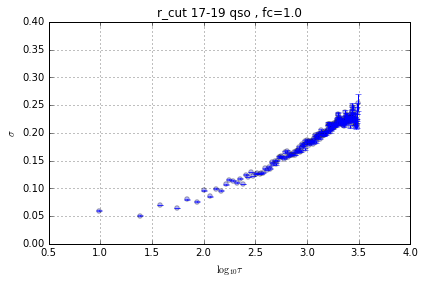

## 11b ) Read in mean_tau , approximate sigma from files, and plot SF 

r_cut_17-18_qso_fc-1.0_mean_tau_sig_approx_err.txt
r_cut_17-18_starsB_fc-1.0_mean_tau_sig_approx_err.txt
r_cut_18-18.5_qso_fc-1.0_mean_tau_sig_approx_err.txt
r_cut_18-18.5_starsB_fc-1.0_mean_tau_sig_approx_err.txt
r_cut_18.5-19_qso_fc-1.0_mean_tau_sig_approx_err.txt
r_cut_18.5-19_starsB_fc-1.0_mean_tau_sig_approx_err.txt


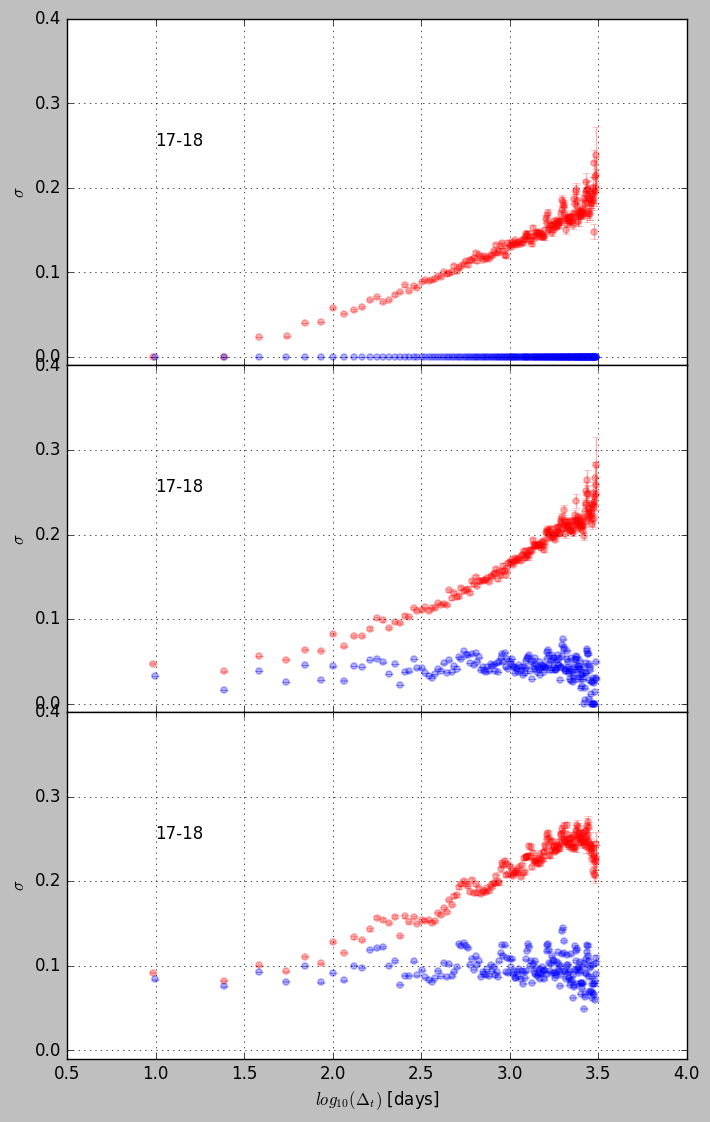

In [697]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams


rcParams['ytick.labelsize'] = 25
rcParams['xtick.labelsize'] = 25
rcParams['axes.labelsize'] = 35
rcParams['axes.linewidth'] = 3
rcParams['font.size'] = 25
rcParams.update({'figure.autolayout': False})
rcParams['legend.numpoints'] = 1

Min_arr = [17, 18, 18.5]
Max_arr = [18, 18.5, 19]
obj_arr = ['qso', 'starsB']
fc_arr =[0.863, 1.091, 1.3]    # Correction factors based on blue stars 
labels_arr = ['Quasars', 'Blue Stars']
colors = ['black','blue']


b = 'r_cut'
fig,ax = plt.subplots(3,1, figsize=(12,12), sharex=True)
fig.subplots_adjust(hspace=0)
for i in range(len(Min_arr)):
    for j in range(len(obj_arr)):
        obj = obj_arr[j]

        fname =  b+'_'+str(Min_arr[i])+'-'+str(Max_arr[i])+'_'+obj+'_fc-'+str(fc_arr[i])+'_mean_tau_sig_approx_err.txt'
        print fname
        d =  np.loadtxt(fname, dtype=float)
        mean_tau = d[:,0]
        sig_approx = d[:,1]
        sig_err = d[:,2]
        ax[i].scatter(np.log10(mean_tau), sig_approx, alpha=0.3, label=labels_arr[j], color=colors[j])
        ax[i].errorbar(np.log10(mean_tau), sig_approx,sig_err, linestyle='None',color=colors[j], alpha=0.3)#
    
    ax[i].text(1.0, 0.25, 'mag: '+str(Min_arr[i])+'-'+str(Max_arr[i]) )
    ax[i].text(1.0, 0.15, 'fc: '+str(fc_arr[i]))
    ax[i].set_ylabel(r'$SF$')
    ax[i].set_ylim(-0.05,0.45)
    ax[i].set_xlim(0.5, 3.7)
    ax[i].grid() 
    ax[i].hlines(y=0.1, xmin =0.5, xmax=1.5, color='green', lw = 4, alpha = 0.8  )

#axs[i].grid(axis='x')

    ax[i].set_yticks([0,0.1,0.2,0.3,0.4])
    ax[i].set_yticklabels(['0.0','0.1', '0.2', '0.3', '0.4'])
    
axbox = ax[0].get_position()
x_value=0.3
y_value=0.15
legend = ax[0].legend(fancybox=True,loc=(axbox.x0 + x_value, axbox.y0 - y_value))

#legend.get_frame().set_edgecolor('1.0')
legend.get_frame().set_alpha(0.5)
plt.rc('legend',**{'fontsize':6})
#plt.setp(plt.gca().get_legend().get_texts(), fontsize='12')

ax[-1].set_xlabel(r'$log_{10} (\Delta {t})$ [days]') 
    
#ax[-1].set_xlabel(r'$\log_{10}{\tau}$', fontsize=20)
plt.show()
#plt.savefig('poster_SF_QSO_starsB_r_cut_fc-'+str(fc_arr[0])+'-'+str(fc_arr[1])+'-'+str(fc_arr[2])+'.png')

In [590]:
plt.show()